In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import scipy.constants as sc

# Functions

In [2]:
def generate_delta_sampling(delta_min, delta_max, step=None, num_points=None):
    if step is None and num_points is None:
        raise ValueError("Either 'step' or 'num_points' must be provided.")
    if step is None:
        step = (delta_max - delta_min) / num_points

    i_min = int(np.ceil(delta_min / step))
    i_max = int(np.floor(delta_max / step))

    arr = step * np.arange(i_min, i_max + 1)
    return arr

In [3]:
def twiss_scan(line, delta_min, delta_max, step=None, num_points=None):
    delta_values = generate_delta_sampling(delta_min, delta_max, step, num_points)
    
    idx_zero = np.where(delta_values == 0)[0][0]
    tw0 = line.twiss4d(delta0=0.0)
    twisses = []
    # twiss_pos.append(tw0)
    # twiss_neg.append(tw0)

    for delta in delta_values[:idx_zero][::-1]:
        twisses.append(line.twiss4d(delta0=delta, co_guess=twisses[-1].particle_on_co) if len(twisses)>0 else tw0)
    twisses = twisses[::-1]
    twisses.append(tw0)
    for delta in delta_values[idx_zero + 1:]:
        twisses.append(line.twiss4d(delta0=delta, co_guess=twisses[-1].particle_on_co))
    
    return delta_values, twisses

# Line

In [ ]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json') ## cavities on!!
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
    # line[name].voltage = 0.0
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

# remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

tte = env.elements.get_table()
mask_rbends = tte.element_type == 'RBend'
mask_quads = tte.element_type == 'Quadrupole'
mask_sextupoles = tte.element_type == 'Sextupole'

mba = tte.rows[mask_rbends].rows['mba.*'].name
mbb = tte.rows[mask_rbends].rows['mbb.*'].name
qf = tte.rows[mask_quads].rows['qf.*'].name
qd = tte.rows[mask_quads].rows['qd.*'].name
lsf = tte.rows[mask_sextupoles].rows['lsf.*'].name
lsd = tte.rows[mask_sextupoles].rows['lsd.*'].name

for nn in mba:
    env[nn].knl = np.array([0., 0., 2.12e-3, 0., -5.74, 0.])

for nn in mbb:
    env[nn].knl = np.array([0., 0., -3.19e-3, 0., -5.10, 0.])

for nn in qf:
    env[nn].knl = np.array([0., 0., 0., 0.75e-1, 0., -0.87e3])

for nn in qd:
    env[nn].knl = np.array([0., 0., 0., -2.03e-1, 0., 2.04e3])


env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           
                                             
Optimize - start penalty: 13.73                             
Matching: model call n. 13 penalty = 3.3521e-06              
Optimize - end penalty:  3.35215e-06                            


In [46]:
line.to_json('sps_q20_inj_errs_matched.json')

# Frederik twisses

In [5]:
def calculate_bucket_height(line, f_RF=200.26e6, V_RF=3e6):
    # Calculate bucket height
    tw_ref = line.twiss4d()
    beta0 = line.particle_ref.beta0[0]
    E = line.particle_ref.energy0[0]
    q = line.particle_ref.q0
    h = f_RF * line.get_length() / beta0 / sc.c
    eta = tw_ref.slip_factor
    return np.sqrt(2*q*V_RF / (np.pi*h*abs(eta)*E*beta0**2))

def get_twisses(line, bucket_height):
    # Perform a bunch of twisses for different delta0
    tw = {}
    beam_sizes = {}
    nemitt = 2e-6
    for delta in np.linspace(-2*bucket_height, 2*bucket_height, 101):
        this_delta = round(delta,6)
        try:
            tw[this_delta] = line.twiss4d(delta0=delta)
            beam_sizes[this_delta] = tw[this_delta].get_beam_covariance(nemitt_x=nemitt, nemitt_y=nemitt)
        except:
            print(f"Failed for delta0={delta}")
            pass
    return tw, beam_sizes

In [11]:
tw, beam_sizes = get_twisses(line, calculate_bucket_height(line, V_RF=3e6))



Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=-0.00596372923757783


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.00596372923757783


In [7]:
from make_aperture import tt_aper
import mplcursors

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


# Initial figure

In [12]:
tw0 = line.twiss()

In [14]:
figsize=(13.33, 6)
xlim = (tw0.rows['qf.60810'].s, tw0.rows['qf.61410'].s)
ylim=(-0.1,0.1)
bucket_height = calculate_bucket_height(line, V_RF=3e6)

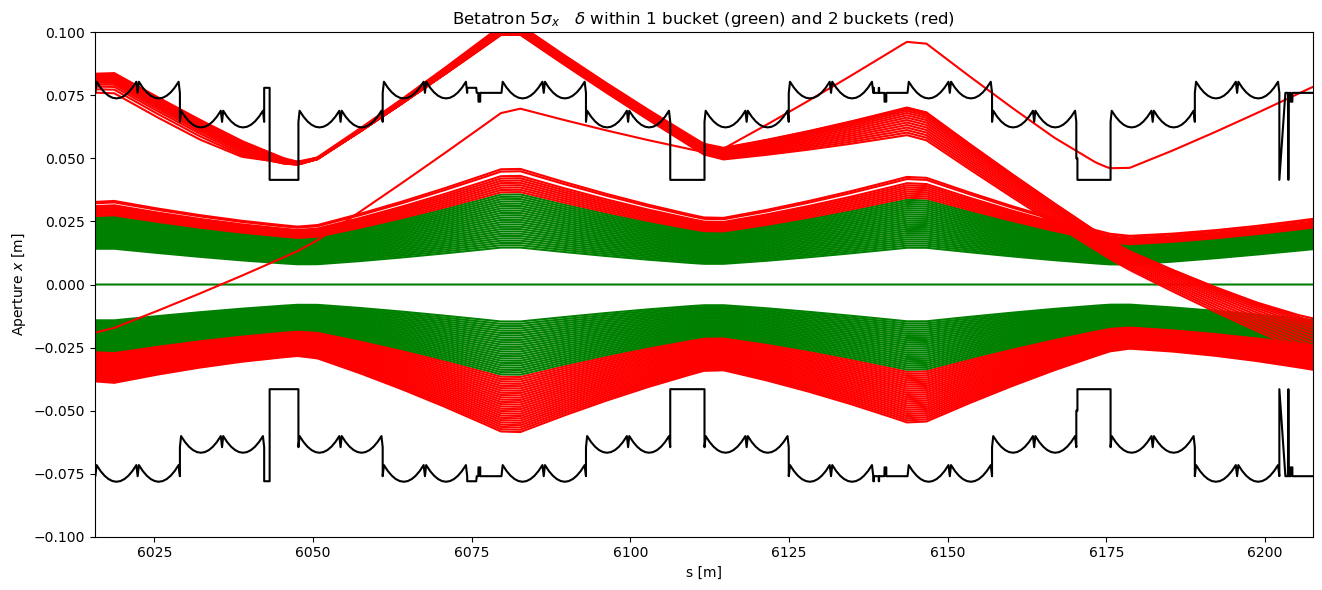

In [19]:
fig, ax = plt.subplots(figsize=figsize)
delta = list(tw.keys())
for dd in delta:
    if abs(dd) <= bucket_height + 1.e-12:
        ax.plot(tw[dd].s, tw[dd].x + np.sign(dd)*5*beam_sizes[dd].sigma_x, 'g-')
    else:
        ax.plot(tw[dd].s, tw[dd].x + np.sign(dd)*5*beam_sizes[dd].sigma_x, 'r-')
line1, = ax.plot(tt_aper.s, tt_aper.aper_max_x, 'k-')
line2, = ax.plot(tt_aper.s, tt_aper.aper_min_x, 'k-')
ax.set_xlabel('s [m]')
ax.set_ylabel('Aperture $x$ [m]')
ax.set_title(f'Betatron {5}' + r'$\sigma_x$   $\delta$ within 1 bucket (green) and 2 buckets (red)')
if xlim is not None:
    ax.set_xlim(xlim)
if ylim is not None:
    ax.set_ylim(ylim)
fig.tight_layout()

## Other colormap

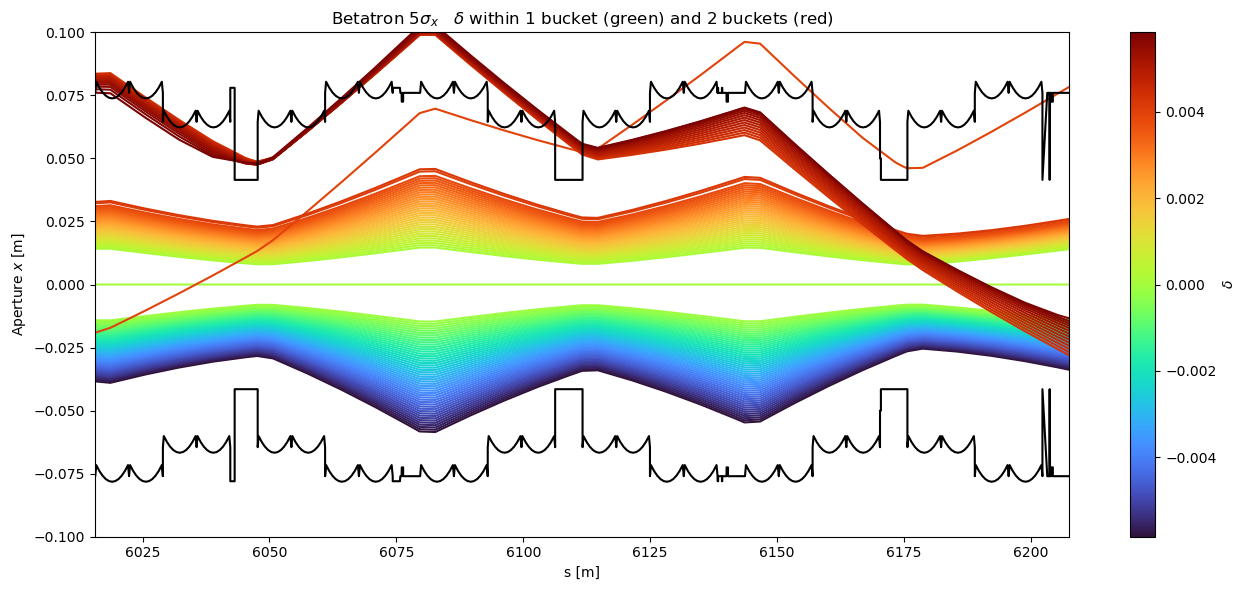

In [25]:
fig, ax = plt.subplots(figsize=figsize)
delta = np.array(list(tw.keys()))
norm = mcolors.Normalize(vmin=delta.min(), vmax=delta.max())
cmap = plt.cm.turbo
for dd in delta:
    ax.plot(tw[dd].s, tw[dd].x + np.sign(dd)*5*beam_sizes[dd].sigma_x, color=cmap(norm(dd)))
line1, = ax.plot(tt_aper.s, tt_aper.aper_max_x, 'k-')
line2, = ax.plot(tt_aper.s, tt_aper.aper_min_x, 'k-')
ax.set_xlabel('s [m]')
ax.set_ylabel('Aperture $x$ [m]')
ax.set_title(f'Betatron {5}' + r'$\sigma_x$   $\delta$ within 1 bucket (green) and 2 buckets (red)')

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\delta$')
if xlim is not None:
    ax.set_xlim(xlim)
if ylim is not None:
    ax.set_ylim(ylim)
fig.tight_layout()

# Last 20 twisses

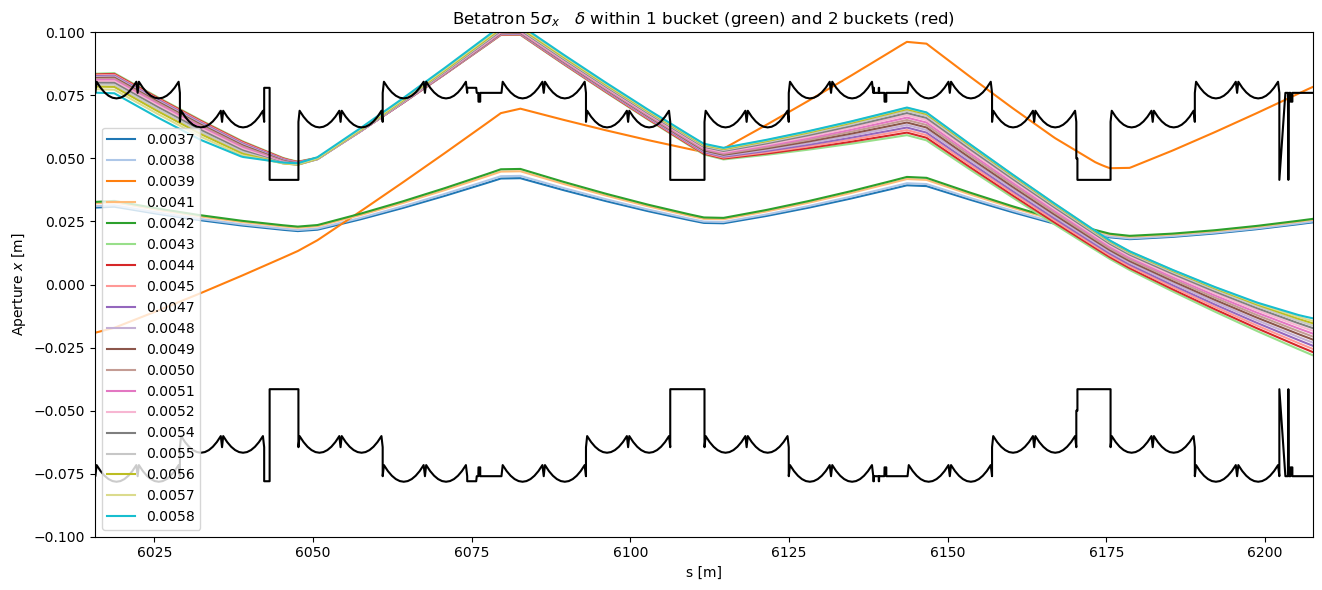

In [35]:
fig, ax = plt.subplots(figsize=figsize)
delta = np.array(list(tw.keys()))
# norm = mcolors.Normalize(vmin=delta.min(), vmax=delta.max())
cmap = plt.cm.tab20
for i, dd in enumerate(delta[80:]):
    ax.plot(tw[dd].s, tw[dd].x + np.sign(dd)*5*beam_sizes[dd].sigma_x, color=cmap(i), label=f'{dd:.4f}')
line1, = ax.plot(tt_aper.s, tt_aper.aper_max_x, 'k-')
line2, = ax.plot(tt_aper.s, tt_aper.aper_min_x, 'k-')
ax.set_xlabel('s [m]')
ax.set_ylabel('Aperture $x$ [m]')
ax.set_title(f'Betatron {5}' + r'$\sigma_x$   $\delta$ within 1 bucket (green) and 2 buckets (red)')
if xlim is not None:
    ax.set_xlim(xlim)
if ylim is not None:
    ax.set_ylim(ylim)
ax.legend()
fig.tight_layout()

In [37]:
idx = 82

In [49]:
print(f'{float(delta[idx]):.14e}')

3.87200000000000e-03


In [ ]:
tw[delta[idx]].qx, tw[delta[idx]].qy # Not a resonance?

(np.float64(19.947867403557538), np.float64(20.393735912174453))

# More twisses around that point

In [32]:
def get_twisses2(line, delta_min, delta_max, num_points=101):
    # Perform a bunch of twisses for different delta0
    tw = {}
    beam_sizes = {}
    nemitt = 2e-6
    for delta in np.linspace(delta_min, delta_max, num_points):
        this_delta = round(delta,6)
        try:
            tw[this_delta] = line.twiss4d(delta0=delta)
            beam_sizes[this_delta] = tw[this_delta].get_beam_covariance(nemitt_x=nemitt, nemitt_y=nemitt)
        except:
            print(f"Failed for delta0={delta}")
            pass
    return tw, beam_sizes

In [33]:
twisses2, beam_sizes2 = get_twisses2(line, 0.0037, 0.0058, num_points=1001)



Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.0038764000000000003


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.0038785


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.0038806


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.0038827


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.0038848


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.

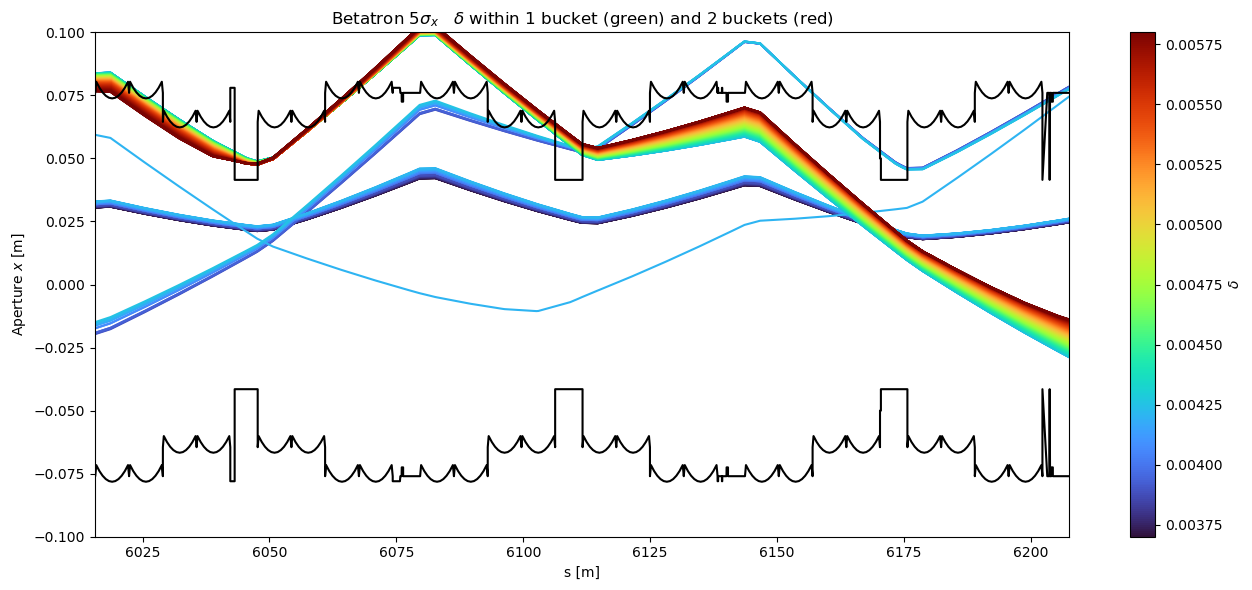

In [34]:
fig, ax = plt.subplots(figsize=figsize)
delta = np.array(list(twisses2.keys()))
norm = mcolors.Normalize(vmin=delta.min(), vmax=delta.max())
cmap = plt.cm.turbo
for dd in delta:
    ax.plot(twisses2[dd].s, twisses2[dd].x + np.sign(dd)*5*beam_sizes2[dd].sigma_x, color=cmap(norm(dd)))
line1, = ax.plot(tt_aper.s, tt_aper.aper_max_x, 'k-')
line2, = ax.plot(tt_aper.s, tt_aper.aper_min_x, 'k-')
ax.set_xlabel('s [m]')
ax.set_ylabel('Aperture $x$ [m]')
ax.set_title(f'Betatron {5}' + r'$\sigma_x$   $\delta$ within 1 bucket (green) and 2 buckets (red)')

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\delta$')
if xlim is not None:
    ax.set_xlim(xlim)
if ylim is not None:
    ax.set_ylim(ylim)
fig.tight_layout()

# Initial guess for twiss

In [43]:
def get_twisses3(line, delta_min, delta_max, num_points=101, co_guess_trig=False):
    # Perform a bunch of twisses for different delta0
    tw = {}
    beam_sizes = {}
    nemitt = 2e-6
    if co_guess_trig:
        co_guess = line.twiss4d(delta0=delta_min).particle_on_co
    for delta in np.linspace(delta_min, delta_max, num_points):
        this_delta = round(delta,6)
        try:
            if co_guess_trig:
                tw[this_delta] = line.twiss4d(delta0=delta, co_guess=co_guess)
                beam_sizes[this_delta] = tw[this_delta].get_beam_covariance(nemitt_x=nemitt, nemitt_y=nemitt)
                co_guess = tw[this_delta].particle_on_co
            else:
                tw[this_delta] = line.twiss4d(delta0=delta)
                beam_sizes[this_delta] = tw[this_delta].get_beam_covariance(nemitt_x=nemitt, nemitt_y=nemitt)
        except:
            print(f"Failed for delta0={delta}")
            pass
    return tw, beam_sizes

In [44]:
twisses3, beam_sizes3 = get_twisses3(line, 0.0037, 0.0058, num_points=1001, co_guess_trig=True)

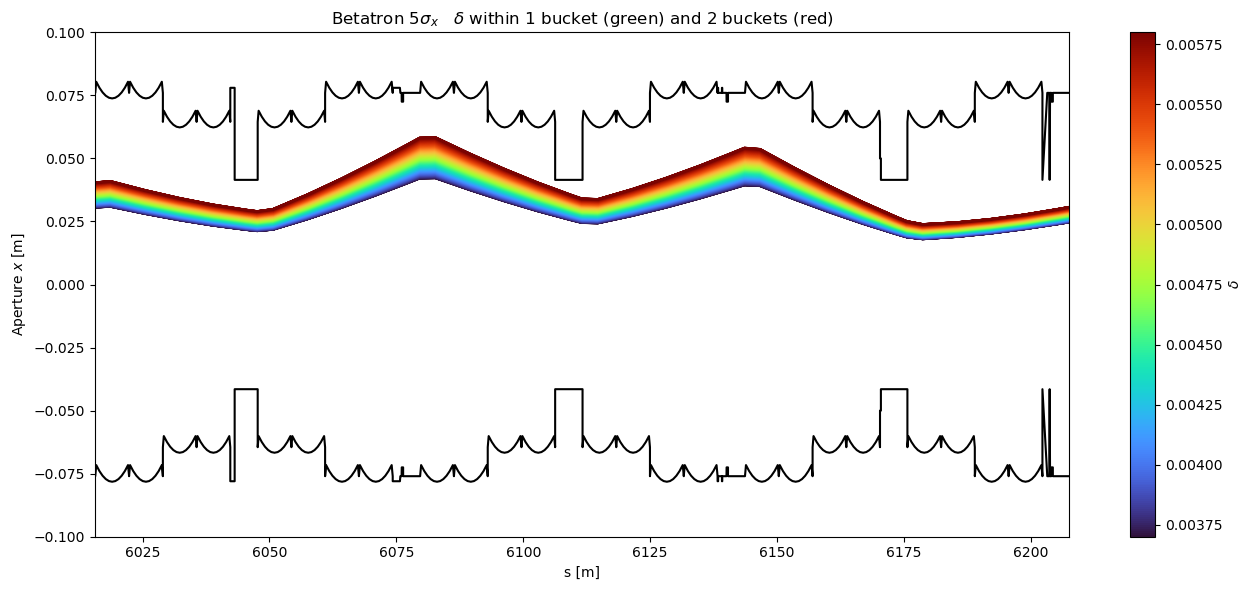

In [45]:
fig, ax = plt.subplots(figsize=figsize)
delta = np.array(list(twisses3.keys()))
norm = mcolors.Normalize(vmin=delta.min(), vmax=delta.max())
cmap = plt.cm.turbo
for dd in delta:
    ax.plot(twisses3[dd].s, twisses3[dd].x + np.sign(dd)*5*beam_sizes3[dd].sigma_x, color=cmap(norm(dd)))
line1, = ax.plot(tt_aper.s, tt_aper.aper_max_x, 'k-')
line2, = ax.plot(tt_aper.s, tt_aper.aper_min_x, 'k-')
ax.set_xlabel('s [m]')
ax.set_ylabel('Aperture $x$ [m]')
ax.set_title(f'Betatron {5}' + r'$\sigma_x$   $\delta$ within 1 bucket (green) and 2 buckets (red)')

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\delta$')
if xlim is not None:
    ax.set_xlim(xlim)
if ylim is not None:
    ax.set_ylim(ylim)
fig.tight_layout()